In [1]:
gdrive = 1

if gdrive:
  
    from google.colab import drive
    drive.mount('/content/drive')
    !curl https://colab.chainer.org/install | sh -

    !pip install cucim
    !pip install scipy scikit-image cupy-cuda100

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# %matplotlib tk
import sys

import numpy as np
#import cupy
import matplotlib.pyplot as plt

In [3]:
oldversion = 0

if oldversion:

  if gdrive :

    sys.path.insert(0,"/content/drive/MyDrive/Repository/HoloTrack")

  else:

    sys.path.insert(0,"./")

  import _deeptrack as dt

else:

  !pip install deeptrack
  import deeptrack as dt

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 7.5 MB/s 
     |████████████████████████████████| 209 kB 61.5 MB/s 
     |████████████████████████████████| 1.1 MB 57.4 MB/s 
     |████████████████████████████████| 12.5 MB 51.8 MB/s 
     |████████████████████████████████| 109 kB 56.7 MB/s 
     |████████████████████████████████| 51 kB 669 kB/s 
     |████████████████████████████████| 251 kB 72.5 MB/s 
     |████████████████████████████████| 546 kB 64.7 MB/s 
  Created wheel for pydeepimagej: filename=pydeepimagej-2.3.3-py3-none-any.whl size=24230 sha256=4dd6f93a28e8f09cbfb007a225a901348bbfa146203f9d155fe6f7f8a2178e70
  Stored in directory: /root/.cache/pip/wheels/4a/05/98/e4bba4aca59759f5e635d6de7d953a9c60a3db586dd2d96dee
Successfully built pydeepimagej
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling sciki

In [4]:
def generate_simulated_image(
    image_size=(64, 64),
    pix_size=5.2,
    z_pix_size = 0.1,#5.2,
    radius=(7.06/2) * 1e-6,
    ri=1.59,
    z=2541,
    apod_val=0.3, # Now it is between 0 and 1 (optimal is somewhere between 0.3 and 0.5)
    sigma = 0.025,
    add_noise=False,
):
    """
    Generates a simulated image with the given parameters.

    Parameters
    ----------
    image_size : tuple
        The size of the image to be generated.
    pix_size : float
        The size of the pixels in the image.
    radius : float
        The radius of the sphere.
    ri : float
        The refractive index of the sphere.
    z : float
        The distance of the sphere from the camera.
    apod_val : float
        The apodization value of the sphere.
    Returns
    -------
    image : ndarray
        The simulated image.
    """

    sphere_main = dt.Sphere(
        position=(32, 32),
        position_unit="pixel",
        cam_pix_size=pix_size,
        radius=radius,
        refractive_index=ri,
        z=z / z_pix_size,
    )

    optics = dt.Brightfield(
        wavelength=633e-9,
        NA=1,
        resolution=[pix_size * 1e-6, pix_size * 1e-6, z_pix_size * 1e-6],
        magnification=1,
        refractive_index_medium=1.33,
        #upscale=1,
        #padding = 1*[1,1,1,1],
        pupil = dt.GaussianApodization(sigma=apod_val),
        output_region=(0, 0, image_size[0], image_size[1]),
    )

    noise = dt.Gaussian(mu=0, sigma=sigma)

    sphere_main_no = lambda: np.random.randint(1, 2)

    if oldversion:

      sample_normal = sphere_main ** sphere_main_no

    else:

      sample_normal = sphere_main ^ sphere_main_no

    if add_noise:
        image_formed = optics(sample_normal) >> noise
    else:
        image_formed = optics(sample_normal)

    image = image_formed.update().resolve()

    return np.array(image[:,:,0])

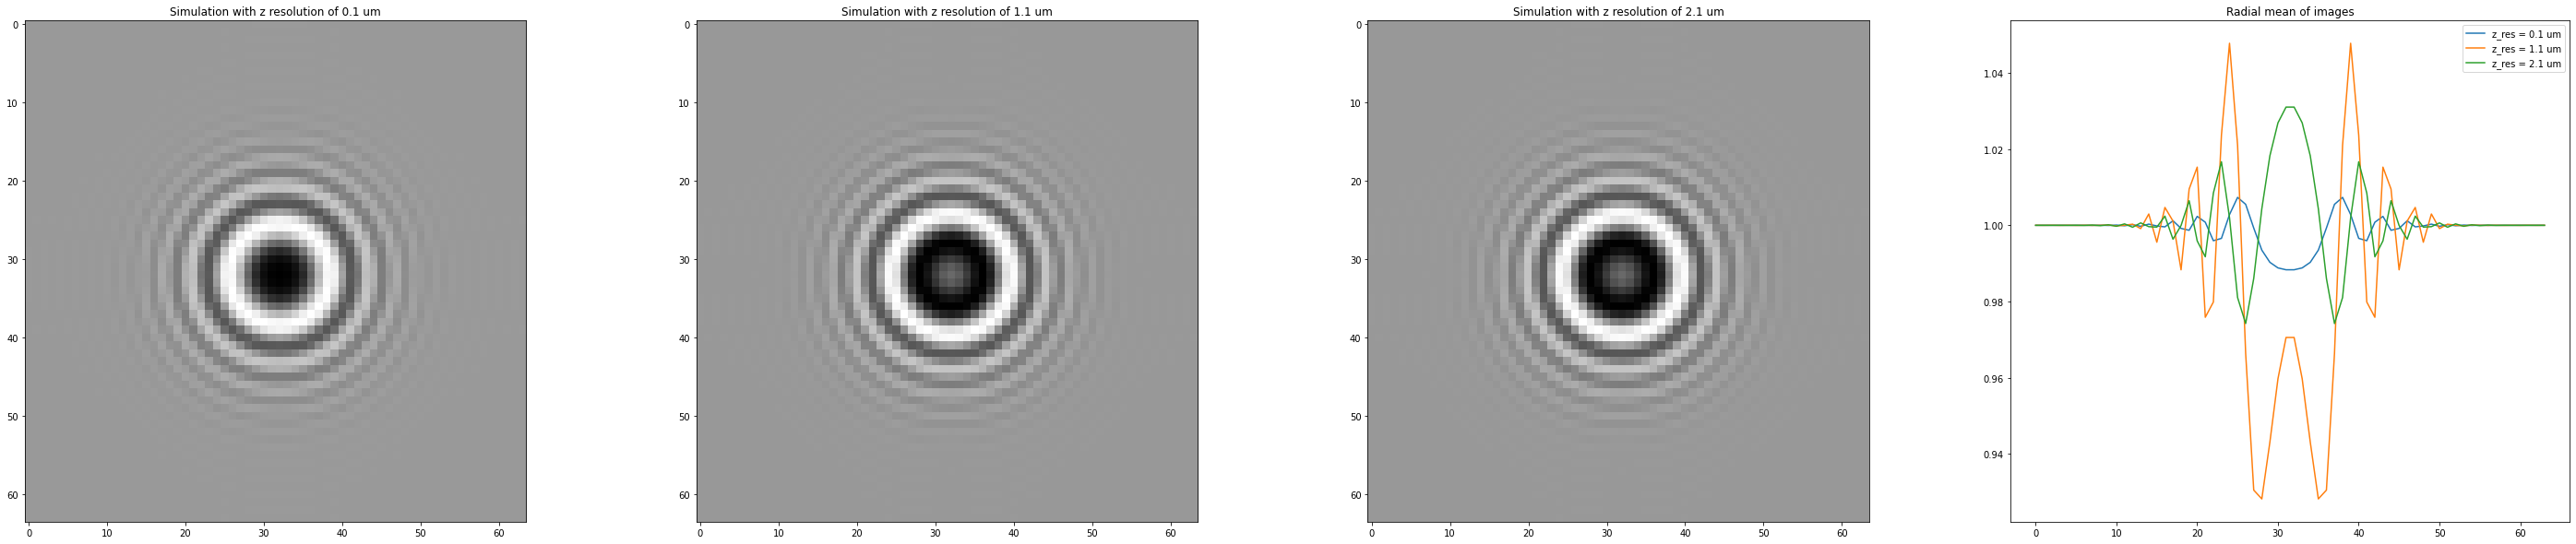

In [5]:
# function to do radial mean
def radial_mean(im):

  x,y = np.meshgrid(np.arange(im.shape[1]),np.arange(im.shape[0]))
  x0,y0 = im.shape[1]/2,im.shape[0]/2
  
  R = np.sqrt((x-x0)**2+(y-y0)**2)
  r0 = np.sqrt(x0**2+y0**2)

  f = lambda r : im[(R >= r-0.5) & (R < r+0.5)].mean()
  r  = np.abs(np.linspace(-im.shape[0]/2,im.shape[0]/2,num=im.shape[0]))

  im_mean = np.vectorize(f)(r)

  return im_mean

zPos = 2445 

image2 = generate_simulated_image(apod_val=0.332, sigma = 0.0015, z = zPos, add_noise=False,z_pix_size = 2.1)
image1 = generate_simulated_image(apod_val=0.332, sigma = 0.0015, z = zPos, add_noise=False,z_pix_size = 1.1)
image0 = generate_simulated_image(apod_val=0.332, sigma = 0.0015, z = zPos, add_noise=False,z_pix_size = 0.1)

plt.figure(figsize=(50, 10))
plt.subplot(1,4,1)
plt.title("Simulation with z resolution of 0.1 um")
plt.imshow(image0, cmap="gray")
plt.subplot(1,4,2)
plt.title("Simulation with z resolution of 1.1 um")
plt.imshow(image1, cmap="gray")
plt.subplot(1,4,3)
plt.title("Simulation with z resolution of 2.1 um")
plt.imshow(image1, cmap="gray")
plt.subplot(1,4,4)
plt.title("Radial mean of images")
plt.plot(radial_mean(image0), label="z_res = 0.1 um")
plt.plot(radial_mean(image1), label="z_res = 1.1 um")
plt.plot(radial_mean(image2), label="z_res = 2.1 um")
plt.legend()